In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import colors
import seaborn as sns
import statistics

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [27]:
retail = pd.read_excel('data/orginal/orders.xlsx')


In [28]:
retail.head(3)

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name
0,262108413,SlcW7YT835JSzh22o7zRCA==,922274,406523,1,139000,2018-08-20 23:59:02,1698,تهران,9,تهران
1,262108413,SlcW7YT835JSzh22o7zRCA==,685868,435013,1,890000,2018-08-20 23:59:02,1698,تهران,9,تهران
2,262108353,NZidrSuPdqoG7RedrFakeA==,275077,163947,1,9890000,2018-08-20 23:58:39,1698,تهران,9,تهران


In [34]:
# New Attribute : Monetary

retail['Monetary']= retail['quantity']*retail['price']
rfm_m = retail.groupby('user_id')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['user_id', 'Monetary']
rfm_m.head()

,user_id,Monetary
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000
1,++HwHhPvBHtXEIN36fDT5w==,1414000
2,++IfjhhQ33j7i4NHdBUJkQ==,990000
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500
4,++XCbp2ChGJyYhM/fYWudg==,1150000


In [35]:
# New Attribute : Frequency

rfm_f = retail.groupby('user_id')['order_id'].nunique()

rfm_f = rfm_f.reset_index()
rfm_f.columns = ['user_id', 'Frequency']
rfm_f.head()

,user_id,Frequency
0,++2u4Q40bTeC0ZZDau1MIQ==,1
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,1
3,++KPSp+1ZC6KXlYAS8VcKg==,1
4,++XCbp2ChGJyYhM/fYWudg==,1


In [36]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['date'] = pd.to_datetime(retail['date'],format='%Y-%m-%d %H:%M:%S')

# Compute the maximum date to know the last transaction date
max_date = retail['date'].max()

# Compute the minimum date to know the last transaction date
min_date = retail['date'].min()

f"this df show orders for {max_date - min_date}"

'this df show orders for 8 days 17:39:43'

In [37]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['date']
retail.tail()


,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Diff,Monetary
199995,258838077,chbca7XuHDG/7OJPls3fNA==,494706,340247,1,40000,2018-08-12 06:21:26,1698,تهران,9,تهران,8 days 17:37:36,40000
199996,258838077,chbca7XuHDG/7OJPls3fNA==,823091,389988,1,325000,2018-08-12 06:21:26,1698,تهران,9,تهران,8 days 17:37:36,325000
199997,258838077,chbca7XuHDG/7OJPls3fNA==,483089,334477,1,1750000,2018-08-12 06:21:26,1698,تهران,9,تهران,8 days 17:37:36,1750000
199998,258838077,chbca7XuHDG/7OJPls3fNA==,1129695,640539,1,184000,2018-08-12 06:21:26,1698,تهران,9,تهران,8 days 17:37:36,184000
199999,258838041,OVCXfcaxQtqLzmy1U8A7eg==,1033353,568751,1,170000,2018-08-12 06:19:19,1442,بوکان,3,آذربایجان غربی,8 days 17:39:43,170000


In [38]:
# Compute last transaction date to get the recency of customers
rfm_r = retail.groupby('user_id')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.columns = ['user_id', 'Recency']
rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r.head()


,user_id,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,0
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,7
3,++KPSp+1ZC6KXlYAS8VcKg==,6
4,++XCbp2ChGJyYhM/fYWudg==,8


In [39]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='user_id', how='inner')
rfm = pd.merge(rfm, rfm_r, on='user_id', how='inner')

rfm.head()

,user_id,Monetary,Frequency,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,1,0
1,++HwHhPvBHtXEIN36fDT5w==,1414000,1,1
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1,7
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,1,6
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1,8


In [40]:
# Removing (statistical) outliers for attribute
all_attributes = ['Monetary','Frequency','Recency']
for attribute in all_attributes:
    Q1 = rfm[attribute].quantile(0.05)
    Q3 = rfm[attribute].quantile(0.95)
    IQR = Q3 - Q1
    rfm = rfm[(rfm[attribute] >= Q1 - 1.5*IQR) & (rfm[attribute] <= Q3 + 1.5*IQR)]

In [65]:
rfm.shape

(55133, 6)

In [69]:
rfm = rfm[rfm['Frequency']>=2]
rfm.shape

In [70]:
rfm_df = rfm[all_attributes]

In [71]:
rfm_df.shape

(9928, 3)

In [72]:
# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(9928, 3)

# Building the Model


In [92]:
CLUSTERING = 3

In [83]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=CLUSTERING, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [84]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

<ipython-input-84-8d48f5dc2726>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster_Id'] = kmeans.labels_


,user_id,Monetary,Frequency,Recency,cluster_id,Cluster_Id
7,++aFMHHDKluZF2DJXQ4VVg==,880000,2,5,1,2
8,++fz+vTHQnkgPIU4nFLwqg==,7021000,2,0,0,1
14,+/4x52C5GE58tU5a4oiIoA==,19120000,3,1,2,0
38,+0NLplvuXBK8B57SSP/BPw==,7290000,2,0,0,1
39,+0PlX9fbkOLljCIpz6XPLw==,1528800,2,3,0,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

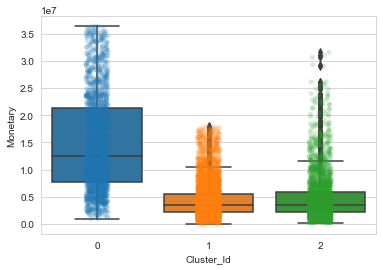

In [85]:
sns.set_style('whitegrid')
sns.boxplot(x='Cluster_Id',y='Monetary',data=rfm )
sns.stripplot(x="Cluster_Id", y="Monetary",data=rfm,   alpha=0.2 )

In [86]:
rfm['Cluster_Id'].value_counts()

1    5637
2    2602
0    1689
Name: Cluster_Id, dtype: int64

In [90]:
retail[retail['user_id'].isin(rfm[rfm['Cluster_Id']==0]['user_id'])].head(1)

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Diff,Monetary
0,262108413,SlcW7YT835JSzh22o7zRCA==,922274,406523,1,139000,2018-08-20 23:59:02,1698,تهران,9,تهران,0 days,139000


In [91]:
cluster_members = []

In [94]:
for i in range(CLUSTERING):
    cluster_members.append(retail[retail['user_id'].isin(rfm[rfm['Cluster_Id'] == i ]['user_id'])])

In [102]:
pivot_table = cluster_members[0].pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)

In [103]:
pivot_table

product_id,1482,2157,2854,3288,3914,4486,4822,5165,5256,5289,...,763143,763175,763202,763212,763278,763470,764412,765117,766245,767740
user_id,,,,,,,,,,,,,,,,,,,,,
+/4x52C5GE58tU5a4oiIoA==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+0Z8Z8H1GzgQNkXLT1XZOQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+2aNkBTZn8DfF2sk4heGpQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+4DlQFQ4veXWhw9z1aGEFw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+EukDLC1vahipDOtWd8ApQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zgHPNS3i8dBAR0OUTNtaeg==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zmdSHt5Euoo5GTAmnBtIlw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zpVb2X0nd2IO49aDoG07ow==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
product_order = pivot_table[5289]
similarity_with_other_product = pivot_table.corrwith(product_order)  
similarity_with_other_product = similarity_with_other_product.sort_values(ascending=False)
similarity_with_other_product.head()

product_id
5289      1.000000
254341    1.000000
81067     0.000592
199616   -0.000592
684056   -0.000592
dtype: float64

In [111]:
pivot_table_1 = cluster_members[1].pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)

In [116]:
product_order = pivot_table_1[5289]
similarity_with_other_product = pivot_table_1.corrwith(product_order)  
similarity_with_other_product = similarity_with_other_product.sort_values(ascending=False)
similarity_with_other_product.head()

product_id
5289      1.000000
550118    0.707044
715927    0.707044
490464    0.707044
338148    0.499823
dtype: float64

In [118]:
pivot_table_2 = cluster_members[2].pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)

In [119]:
product_order = pivot_table_2[5289]
similarity_with_other_product = pivot_table_2.corrwith(product_order)  
similarity_with_other_product = similarity_with_other_product.sort_values(ascending=False)
similarity_with_other_product.head()

product_id
5289      1.000000
550936    0.706971
550916    0.706971
551515    0.706971
549350    0.706971
dtype: float64

In [123]:
retail[retail['product_id']==254341]

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Diff,Monetary
119560,260059701,bQmdmm8gW2yhfMV0tm/7lw==,599082,254341,1,26400000,2018-08-15 16:58:36,2326,دهدشت,24,کهگیلویه و بویراحمد,5 days 07:00:26,26400000
148713,259608429,nwTy1Ni2EiwGzPPKv/45yQ==,599082,254341,1,26400000,2018-08-14 11:51:49,1698,تهران,9,تهران,6 days 12:07:13,26400000


In [ ]:
# pivot_table_main = retail.pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)